# Cox生存分析

* `mydir`：自己的数据
* `ostime_column`: 数据对应的生存时间，不一定非的是OST，也可以是DST、FST等。
* `os`：生存状态，不一定非的是OS，也可以是DS、FS等。

In [1]:
from lifelines import CoxPHFitter
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df
from sklearn.model_selection import train_test_split
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.comp1 import fillna

task_type = 'Clinical_'
event_col = get_param_in_cwd('event_col', 'label')
duration_col=get_param_in_cwd('duration_col', 'time')
data = pd.read_csv('data/clinical.csv')
# data = normalize_df(data, not_norm='ID')
data

,ID,T,N,M,Degree,DU,BILE,胰周脂肪,脉管癌栓,胰周神经,胰内神经,Sex,Age,OSTime,OS,group
0,1238060,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1,56,4.50,0,train
1,1240023,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1,39,28.47,0,train
2,1310929,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0,65,5.73,1,test
3,1320927,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1,56,7.30,1,test
4,1322885,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1,68,4.87,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2017433,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1,48,22.23,1,test
696,2018527,1.0,0.0,1.0,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1,78,5.07,0,train
697,2018539,4.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1,71,16.73,1,train
698,2018734,3.0,2.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,0,72,10.93,1,test


In [2]:
import numpy as np
import onekey_algo.custom.components as okcomp
from collections import OrderedDict

group_info = 'group'
train_data = data[(data[group_info] == 'train')]

# subsets = [s for s in label_data['group'].value_counts().index if s != 'train']
subsets = ['train', 'test']
val_datasets = OrderedDict()
for subset in subsets:
    val_data = data[data[group_info] == subset]
    val_datasets[subset] = val_data
    val_data.to_csv(f'features/{task_type}_{subset}_features_norm.csv', index=False)

print('，'.join([f"{subset}样本数：{d_.shape}" for subset, d_ in val_datasets.items()]))

train样本数：(490, 16)，test样本数：(210, 16)


## Cox概览

所有Cox回归的必要数据，主要关注的数据有3个
1. `Concordance`: c-index
2. `exp(coef)`: 每个特征对应的HR，同时也有期对应的95%分位数。
3. `p`: 表示特征是否显著。

In [3]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)
cph.fit(train_data[[c for c in train_data.columns if c not in ['ID', 'group']]], duration_col=duration_col, event_col=event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 490 total observations, 136 right-censored observations>
             duration col = 'OSTime'
                event col = 'OS'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 490
number of events observed = 354
   partial log-likelihood = -1895.07
         time fit was run = 2024-03-24 14:21:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
T           0.12       1.13       0.08            -0.02             0.27                 0.98                 1.31
N           0.14       1.16       0.07             0.02             0.27                 1.02                 1.31
M           0.13       1.14       0.20            -0.26             0.52                 0.77                 1.68
Degree      0.16       1.17       0.04             0.09             0.23                 1.09                 1.26
DU          0.05       1.05       0.11            -0.17             0.28                 0.84                 1.32
BILE       -0.19       0.83       0.11            -0.41             0.03                 0.66                 1.03
胰周脂肪       -0.04       0.96       0.13            -0.30             0.22                 0.74                 1.24
脉管癌栓        0.14       1.15       0.11            -0.08             0.36                 0.92                 1.43
胰周神经        0.20       1.22       0.21            -0.21             0.61                 0.81                 1.84
胰内神经        0.50       1.65       0.27            -0.02             1.02                 0.98                 2.78
Sex         0.14       1.15       0.10            -0.06             0.35                 0.94                 1.41
Age         0.02       1.02       0.01             0.01             0.03                 1.01                 1.03

            cmp to     z      p   -log2(p)
covariate                                 
T             0.00  1.64   0.10       3.30
N             0.00  2.21   0.03       5.20
M             0.00  0.67   0.50       0.99
Degree        0.00  4.21 <0.005      15.28
DU            0.00  0.46   0.64       0.64
BILE          0.00 -1.71   0.09       3.53
胰周脂肪          0.00 -0.31   0.76       0.40
脉管癌栓          0.00  1.23   0.22       2.20
胰周神经          0.00  0.97   0.33       1.58
胰内神经          0.00  1.88   0.06       4.06
Sex           0.00  1.36   0.18       2.51
Age           0.00  3.51 <0.005      11.12
---
Concordance = 0.65
Partial AIC = 3814.13
log-likelihood ratio test = 62.34 on 12 df
-log2(p) of ll-ratio test = 26.82

In [8]:
cph.summary#[cph.summary['p'] < 0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
T,0.123,1.131,0.075,-0.024,0.271,0.976,1.312,0.0,1.636,1.018e-01,3.296
N,0.145,1.155,0.065,0.016,0.273,1.016,1.314,0.0,2.209,2.716e-02,5.202
M,0.132,1.141,0.198,-0.255,0.520,0.775,1.681,0.0,0.668,5.038e-01,0.989
Degree,0.160,1.173,0.038,0.085,0.234,1.089,1.264,0.0,4.213,2.517e-05,15.278
DU,0.053,1.054,0.114,-0.170,0.276,0.843,1.318,0.0,0.463,6.431e-01,0.637
BILE,-0.192,0.825,0.112,-0.412,0.028,0.662,1.028,0.0,-1.713,8.675e-02,3.527
胰周脂肪,-0.040,0.961,0.130,-0.296,0.216,0.744,1.241,0.0,-0.308,7.583e-01,0.399
脉管癌栓,0.138,1.147,0.112,-0.081,0.356,0.922,1.428,0.0,1.233,2.177e-01,2.199
胰周神经,0.201,1.222,0.208,-0.207,0.608,0.813,1.836,0.0,0.965,3.345e-01,1.580


In [14]:
info = pd.DataFrame(cph.summary)[['coef', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']].reset_index()
info['p'] = info['p'].map(lambda x: '<0.05' if x < 0.05 else f"{x:.3f}")
info

,covariate,coef,exp(coef) lower 95%,exp(coef) upper 95%,p
0,T,0.123,0.976,1.312,0.102
1,N,0.145,1.016,1.314,<0.05
2,M,0.132,0.775,1.681,0.504
3,Degree,0.160,1.089,1.264,<0.05
4,DU,0.053,0.843,1.318,0.643
5,BILE,-0.192,0.662,1.028,0.087
6,胰周脂肪,-0.040,0.744,1.241,0.758
7,脉管癌栓,0.138,0.922,1.428,0.218
8,胰周神经,0.201,0.813,1.836,0.334
9,胰内神经,0.501,0.979,2.783,0.060


In [11]:
cph.summary['p'].map(lambda x: '<0.05' if x < 0.05 else f"{x:.3f}")

covariate
T         0.102
N         <0.05
M         0.504
Degree    <0.05
DU        0.643
BILE      0.087
胰周脂肪      0.758
脉管癌栓      0.218
胰周神经      0.334
胰内神经      0.060
Sex       0.175
Age       <0.05
Name: p, dtype: object

#### 输出每个特征的HR

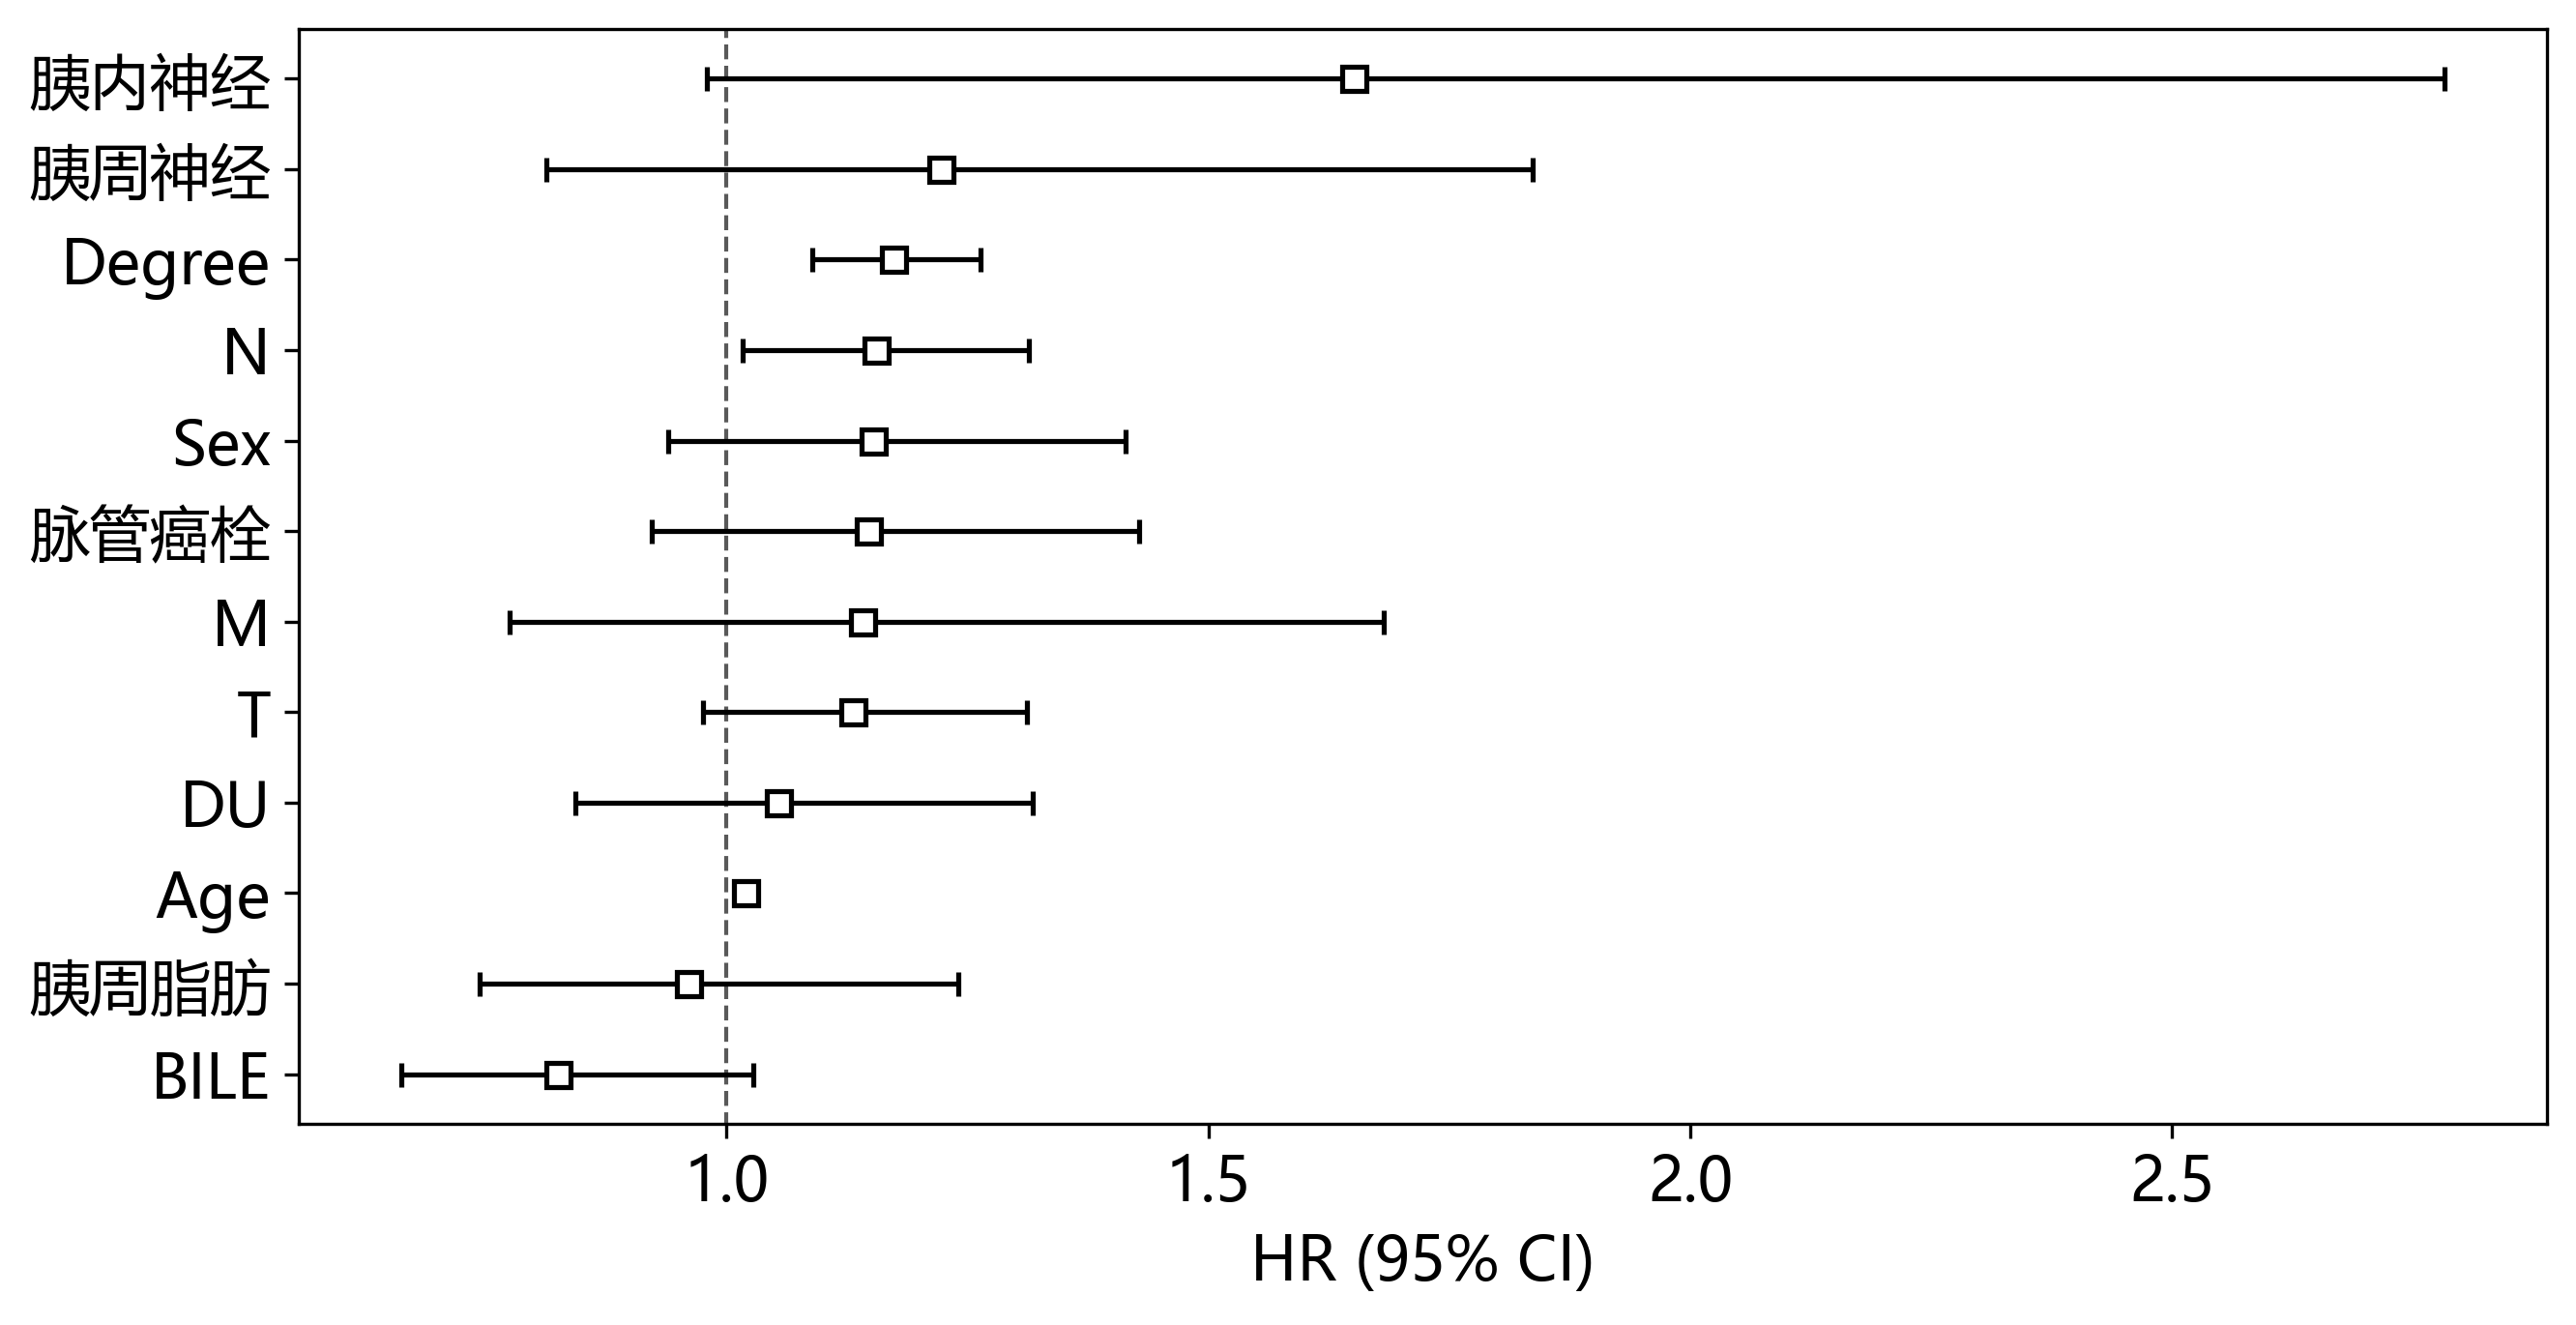

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
cph.plot(hazard_ratios=True)
plt.savefig('img/Clinic_feature_pvalue.svg', bbox_inches='tight')
plt.show()

# KM 曲线

根据HR进行分组，计算KM以及log ranktest

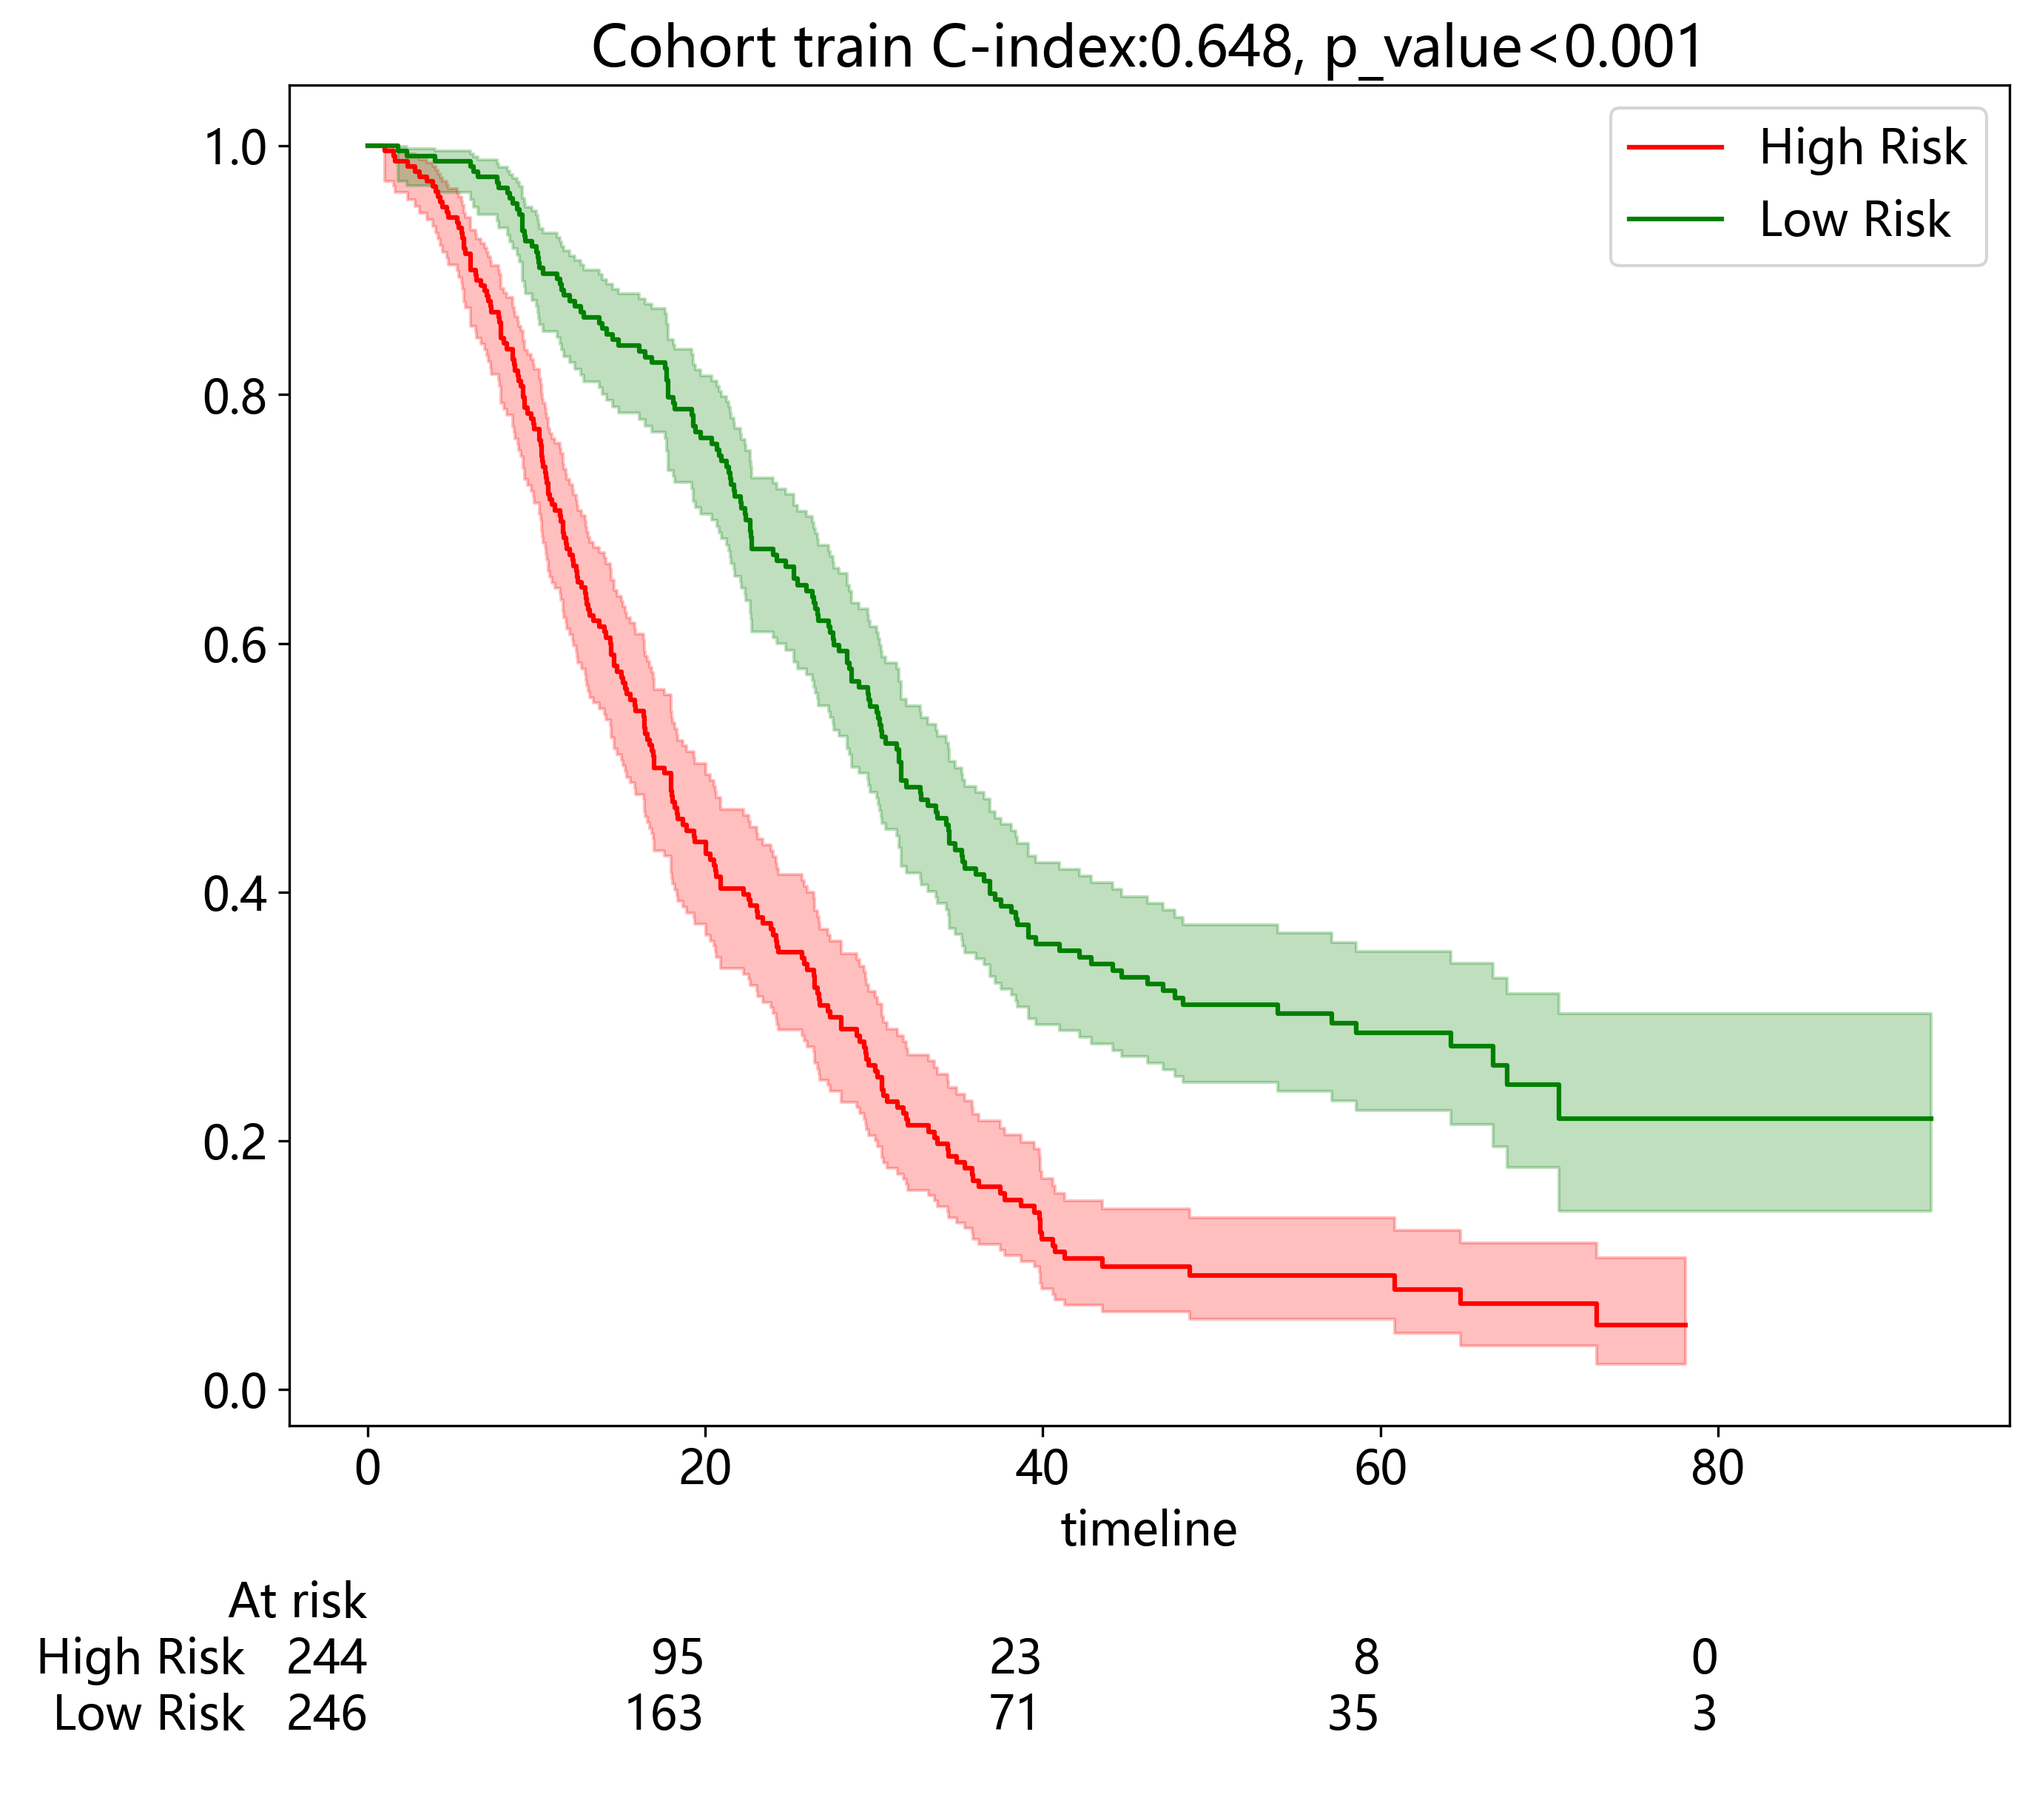

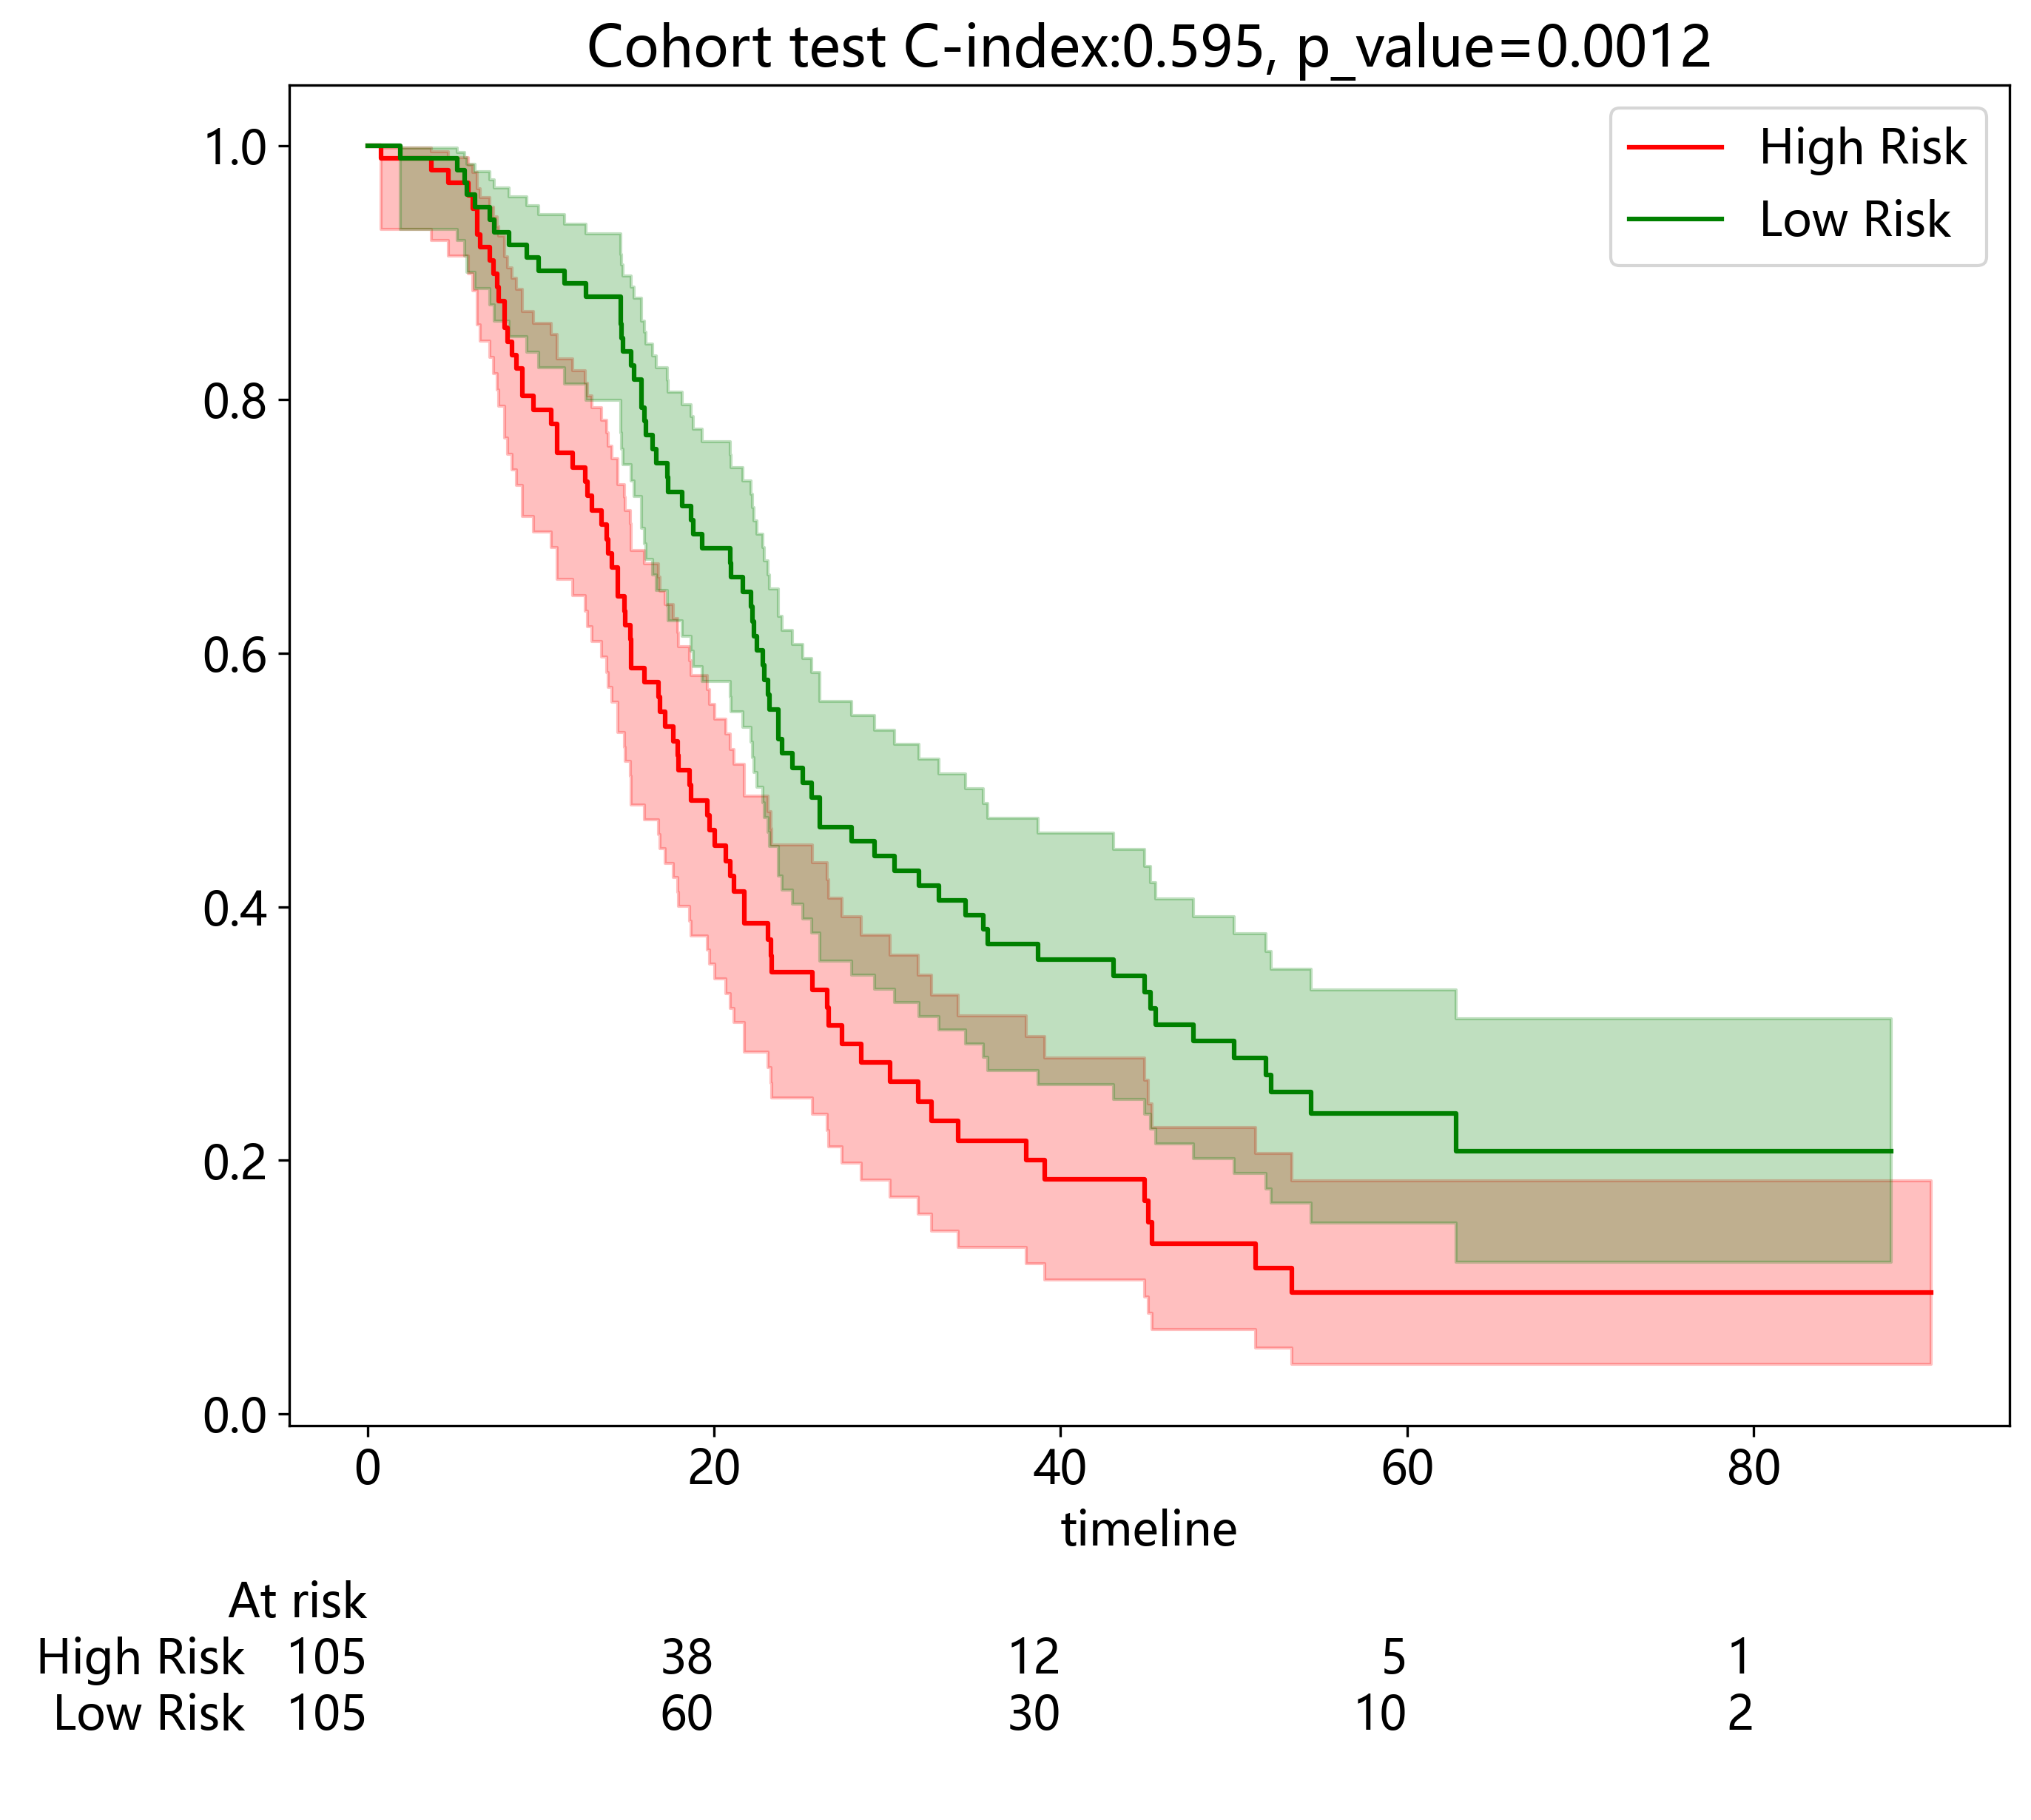

In [6]:
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

for subset, test_data in val_datasets.items():
    if subset == 'test_ex':
        continue
    c_index = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
#     y_pred = cph.predict_median(test_data[[c for c in test_data.columns if c != 'ID']])
#     cox_data = pd.concat([test_data, y_pred], axis=1)
#     mean = cox_data.describe()[0.5]['mean']
#     cox_data['HR'] = cox_data[0.5] < mean
    y_pred = cph.predict_partial_hazard(test_data[[c for c in test_data.columns if c != 'ID']])
    cox_data = pd.concat([test_data, y_pred], axis=1)
    mean = cox_data.describe()[0]['50%']
    cox_data['HR'] = cox_data[0] > mean
#     cox_data['HR'] = cox_data[0] > 1

    dem = (cox_data["HR"] == True)
    results = logrank_test(cox_data[duration_col][dem], cox_data[duration_col][~dem], 
                           event_observed_A=cox_data[event_col][dem], event_observed_B=cox_data[event_col][~dem])
    p_value = f"={results.p_value:.4f}" if results.p_value > 0.001 else '<0.001'
    plt.title(f"Cohort {subset} C-index:{c_index:.3f}, p_value{p_value}")
    if sum(dem):
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(cox_data[duration_col][dem], event_observed=cox_data[event_col][dem], label="High Risk")
        kmf_high.plot_survival_function(color='r')
    if sum(~dem):
        kmf_low = KaplanMeierFitter()
        kmf_low.fit(cox_data[duration_col][~dem], event_observed=cox_data[event_col][~dem], label="Low Risk")
        kmf_low.plot_survival_function(color='g')
    add_at_risk_counts(kmf_high, kmf_low, rows_to_show=['At risk'])
    plt.savefig(f'img/{task_type}KM_{subset}.svg', bbox_inches='tight')
    plt.show()

In [7]:
import os
import numpy as np

def get_prediction(model: CoxPHFitter, data, ID=None, **kwargs):
    hr = model.predict_partial_hazard(data)
    expectation = model.predict_expectation(data)
    
    predictions = pd.concat([hr, expectation], axis=1)
    predictions.columns = ['HR', 'expectation']
    if ID is not None:
        predictions = pd.concat([ID, hr, expectation], axis=1)
        predictions.columns = ['ID', 'HR', 'expectation']
    else:
        predictions = pd.concat([hr, expectation], axis=1)
        predictions.columns = ['HR', 'expectation']
    return predictions
os.makedirs('results', exist_ok=True)
kids = []
for subset, test_data in val_datasets.items():
    resuslts = get_prediction(cph, test_data, ID=test_data['ID'])
    resuslts.to_csv(f'results/{task_type}cox_predictions_{subset}.csv', index=False)
    kids.append(resuslts['ID'])